# 1. Setup and Initialization
This section imports required libraries, initializes the OpenAI API, and downloads necessary NLTK data for tokenization.


In [ ]:
import os
import pandas as pd
import time
import openai
import nltk
from nltk.tokenize import sent_tokenize

# Initialize OpenAI client
openai.api_key = "YOUR-KEY-HERE"

# Download the necessary NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hclu1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 2. Load A1 Units from CSV File
This section reads the A1 units from the CSV file and prints the shape of the resulting unit vector to confirm its size.


In [3]:
# Read A1 units from the specified CSV file
a1_units_path = "A1_Units_Breakfast.csv"

# Load A1 units from the CSV file
a1_units_df = pd.read_csv(a1_units_path)
A1_units = a1_units_df['A1_unit'].tolist()  # Convert the column to a list

# Print the shape of the unit vector
num_units = len(A1_units)
print(f"The shape of the A1 unit vector is: {num_units} x 1")


The shape of the A1 unit vector is: 121 x 1


# 3. Create Detail Mapping
This section maps each A1 unit to a corresponding code (e.g., V1, V2, ...) for easier identification and reference.


In [4]:
# Map each detail in A1_units to a sequential Vn code
detail_mapping = {f"V{i+1}": detail for i, detail in enumerate(A1_units)}

# Display mapping to verify
print("Detail Mapping (Vn codes):")
for code, detail in detail_mapping.items():
    print(f"{code}: {detail}")

Detail Mapping (Vn codes):
V1: walks into kitchen
V2: puts soap on hand
V3: turns on water
V4: lathers and rinses hands under water
V5: turns off water
V6: shakes water off hands
V7: dries hands
V8: opens cupboard
V9: takes out frying pan
V10: close cupboard
V11: puts pan on stove
V12: lights burner
V13: She moves the frying pan to the burner
V14: adjusts flame
V15: opens fridge
V16: takes out eggs and bread
V17: puts eggs and bread on counter
V18: takes butter out of fridge
V19: closes fridge
V20: puts butter on counter 
V21: open bread
V22: takes piece of bread out of bag
V23: open toaster
V24: puts bread in toaster
V25: close toaster
V26: turns on toaster
V27: closes bread bag
V28: opens fridge
V29: puts bread back in fridge
V30: gets OJ out of fridge
V31: closes fridge
V32: puts OJ on counter
V33: opens cupboard
V34: takes juice glass out of cupboard
V35: closes cupboard
V36: puts glass on counter
V37: shakes OJ
V38: takes cap off OJ
V39: pours glass of OJ
V40: puts cap on OJ
V41: 

# 4. Load Participant Responses
This section loads raw participant responses from text files in a specified directory into a DataFrame.


In [5]:
def load_txt_files(input_dir):
    # List all .txt files in the directory
    txt_files = [f for f in os.listdir(input_dir) if f.endswith(".txt")]
    
    if not txt_files:
        print("No .txt files found in the directory.")
        return pd.DataFrame()
    
    print("Available participant responses:")
    for idx, filename in enumerate(txt_files):
        print(f"{idx + 1}: {filename}")
    
    # Prompt user to select files
    print("\nOptions:")
    print("1. Enter indices of the files you want to include (e.g., 1,3,5).")
    print("2. Type 'all' to select all files.")
    selection = input("Enter your choice: ").strip().lower()
    
    if selection == "all":
        selected_files = txt_files
    else:
        try:
            selected_indices = [int(i) - 1 for i in selection.split(",")]
            selected_files = [txt_files[i] for i in selected_indices]
        except (ValueError, IndexError):
            print("Invalid input. Please ensure you enter valid indices.")
            return pd.DataFrame()
    
    # Load selected files into a DataFrame
    participants_responses = []
    for filename in selected_files:
        with open(os.path.join(input_dir, filename), 'r') as file:
            response_text = file.read().strip()
            participants_responses.append({
                'participant': filename.replace(".txt", ""),
                'resp': response_text  # Store raw response text
            })
    
    return pd.DataFrame(participants_responses)

input_directory = r"D:\WashU\Research\FL24_Research\Dynamic_Cognition_Lab\Automated_Grading"
participants_df = load_txt_files(input_directory)

# Display selected responses
if not participants_df.empty:
    print("\nLoaded participant responses:")
    display(participants_df.head())
else:
    print("No responses were loaded.")


Available participant responses:
1: e80001_Movie1.txt
2: e80002_Movie1.txt
3: e80003_Movie1.txt
4: e80004_Movie1.txt
5: e80005_Movie1.txt
6: e80006_Movie1.txt
7: e80007_Movie1.txt
8: e80008_Movie1.txt
9: e80009_Movie1.txt
10: e80010_Movie1.txt
11: e80011_Movie1.txt
12: e80012_Movie1.txt
13: e80013_Movie1.txt
14: e80014_Movie1.txt
15: e80015_Movie1.txt

Options:
1. Enter indices of the files you want to include (e.g., 1,3,5).
2. Type 'all' to select all files.

Loaded participant responses:


,participant,resp
0,e80001_Movie1,a woman walks into the kitchen to make some br...
1,e80002_Movie1,A young woman enters the room and begins to ma...
2,e80003_Movie1,A young woman dressed in jeans and T-shirt ent...
3,e80004_Movie1,A woman walked into a beautifully bright kitch...
4,e80005_Movie1,There is a kitchen and it looks fairly clean. ...


# 5. Tokenize Responses
This section tokenizes the responses in the DataFrame into individual sentences for further processing.


In [6]:
def tokenize_responses(df):
    df['resp'] = df['resp'].apply(sent_tokenize)  # Tokenize each response into sentences
    return df

participants_df = tokenize_responses(participants_df)

# Display a sample of tokenized responses
participants_df.head()


,participant,resp
0,e80001_Movie1,[a woman walks into the kitchen to make some b...
1,e80002_Movie1,[A young woman enters the room and begins to m...
2,e80003_Movie1,[A young woman dressed in jeans and T-shirt en...
3,e80004_Movie1,[A woman walked into a beautifully bright kitc...
4,e80005_Movie1,[There is a kitchen and it looks fairly clean....


# 6. GPT-4 Scoring Function
This section defines a function that uses GPT-4 to check if any A1 units are recalled in a single sentence of the response.


In [7]:
def check_units_in_sentence(details, sentence, active_units):
    # Filter only unmatched details
    current_details = [details[i] for i in range(len(details)) if active_units[i] == 0]
    if not current_details:  # If all units are matched, skip the function
        return

    messages = [
        {"role": "system", "content": "You are a research assistant for a lab studying cognitive psychology."},
        {"role": "user", "content": (
            "You will see DETAILS and a RESPONSE. The RESPONSE is a participant's recollection of actions from a video. "
            "Each action in DETAILS was observed in the video. For each action, compare it to the RESPONSE and assign 1 if "
            "the action was recalled (meaning the verb and object are strictly matched) and 0 if not. "
            "Return a comma-separated list of binary values (0s and 1s) for each action in DETAILS in the provided order."
            f"\n\nDETAILS: {current_details}\nRESPONSE: {sentence}\n\nVECTOR SCORE:"
        )}
    ]
    try:
        completion = openai.chat.completions.create(
            model="gpt-4",
            messages=messages,
            max_tokens=300,
            temperature=0
        )
        
        vector_text = completion.choices[0].message.content.strip().replace("[", "").replace("]", "").replace(" ", "")
        vector = [int(item) for item in vector_text.split(",") if item]

        # Map recalled actions to active_units
        idx = 0
        for i in range(len(active_units)):
            if active_units[i] == 0:  # Only update unrecalled units
                active_units[i] = max(active_units[i], vector[idx])
                idx += 1
                if idx >= len(vector):  # Stop if we reach the end of the vector
                    break

    except Exception as e:
        print(f"Error: {e}")


# 7. Scoring Participant Responses
This section processes each participant's response to calculate recall scores for all A1 units using GPT-4.

In [8]:
def score_recall(targets_and_resps):
    for i, row in targets_and_resps.iterrows():
        response_sentences = row['resp']
        active_units = [0] * num_units  # Initialize all V1 to Vn as 0
        
        for sentence in response_sentences:
            check_units_in_sentence(A1_units, sentence, active_units)
            # Break the loop if all units have been matched
            if all(active_units):
                break
        
        # Store each value in DataFrame as V1, V2, ... Vn
        for j in range(num_units):
            col_name = f"V{j+1}"
            targets_and_resps.at[i, col_name] = active_units[j]

        print(f"Processed {i+1} responses...")
        time.sleep(6)

# Initialize columns V1 to Vn with default value 0
for j in range(num_units):
    col_name = f"V{j+1}"
    participants_df[col_name] = 0

# Perform scoring
score_recall(participants_df)


C:\Users\hclu1\AppData\Local\Temp\ipykernel_8056\866177321.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  participants_df[col_name] = 0
C:\Users\hclu1\AppData\Local\Temp\ipykernel_8056\866177321.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  participants_df[col_name] = 0
C:\Users\hclu1\AppData\Local\Temp\ipykernel_8056\866177321.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

Processed 1 responses...
Processed 2 responses...
Processed 3 responses...
Processed 4 responses...
Processed 5 responses...
Processed 6 responses...
Processed 7 responses...
Processed 8 responses...
Processed 9 responses...
Processed 10 responses...
Processed 11 responses...
Processed 12 responses...
Processed 13 responses...
Processed 14 responses...
Processed 15 responses...


# 8. Save Recall Scores
This section calculates the total recall score (A1_sum) for each participant and saves the results to a CSV file.


In [20]:
# Calculate A1_sum by summing across V1 to Vn for each row
participants_df['A1_sum'] = participants_df[[f"V{i+1}" for i in range(num_units)]].sum(axis=1)

# Define output directory and save results
output_directory = r"DCL\Auto_Grading\data\output"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_file = os.path.join(output_directory, "vector_output.csv")
participants_df.to_csv(output_file, columns=['participant'] + [f"V{i+1}" for i in range(num_units)] + ['A1_sum'], index=False)

print(f"Recall vectors saved to {output_file}")


Recall vectors saved to DCL\Auto_Grading\data\output\vector_output.csv


# 9. Import Visulization Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# 10. Load and Preprocess CSV Files

In [22]:
# Load CSV files
vector_output = pd.read_csv(r'DCL\Auto_Grading\data\output\vector_output.csv')
test_csv = pd.read_csv(r'test\test.csv')

# Set the first column as row identifiers (index)
vector_output = vector_output.set_index(vector_output.columns[0])
test_csv = test_csv.set_index(test_csv.columns[0])

# Process row names in vector_output to remove suffixes like "_Movie1"
vector_output.index = vector_output.index.str.split("_").str[0]

# Find common rows based on processed row names
common_indices = vector_output.index.intersection(test_csv.index)

# Align DataFrames to common rows
vector_output = vector_output.loc[common_indices]
test_csv = test_csv.loc[common_indices]

# Ensure column names are aligned between the two files
common_columns = vector_output.columns.intersection(test_csv.columns)

# Subset DataFrames to include only matching columns
vector_output = vector_output[common_columns]
test_csv = test_csv[common_columns]

# 11. Calculate Similarity Metrics

In [23]:
# Lists to store similarities
cosine_similarities = []
pearson_correlations = []

# Calculate similarities for matched rows
for row_name in vector_output.index:
    vector_output_row = vector_output.loc[row_name].values.reshape(1, -1)
    test_csv_row = test_csv.loc[row_name].values.reshape(1, -1)
    
    # Cosine similarity
    cosine_sim = cosine_similarity(vector_output_row, test_csv_row)[0][0]
    cosine_similarities.append(cosine_sim)
    
    # Pearson correlation
    pearson_corr = np.corrcoef(vector_output_row.flatten(), test_csv_row.flatten())[0, 1]
    pearson_correlations.append(pearson_corr)

# Create a DataFrame for visualization
similarity_df = pd.DataFrame({
    "Row Name": vector_output.index,
    "Cosine Similarity": cosine_similarities,
    "Pearson Correlation": pearson_correlations
})

# 12. Visualize Scatter Plot of Similarities

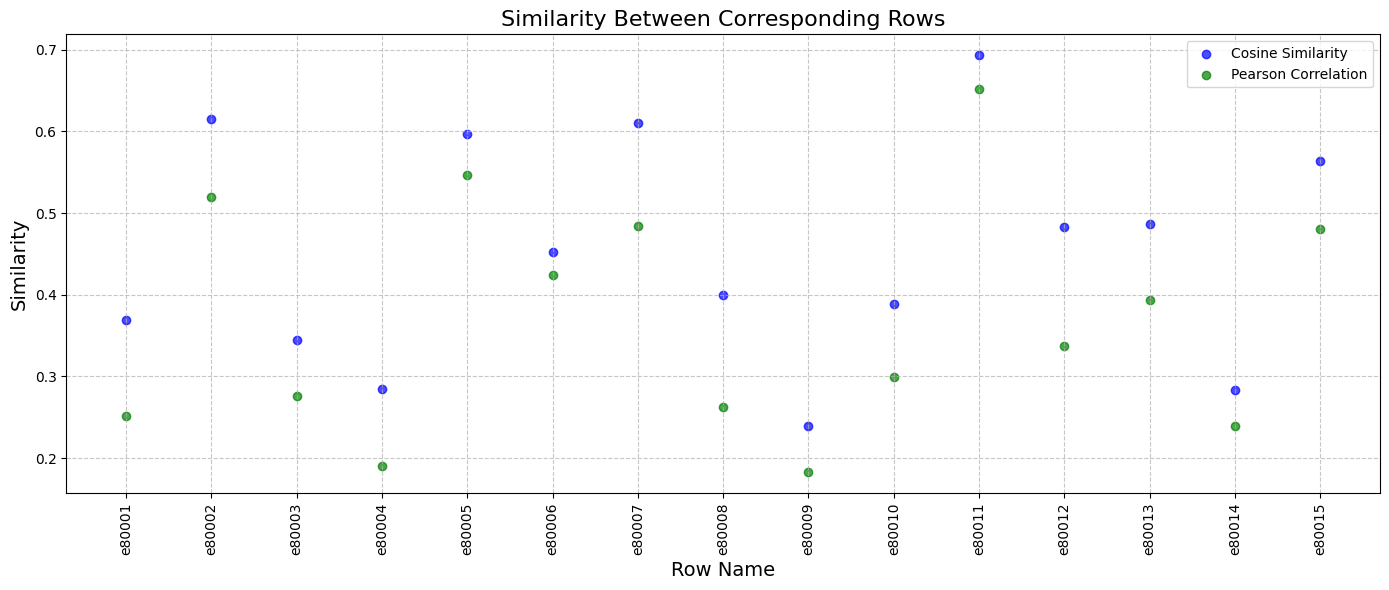

In [24]:
plt.figure(figsize=(14, 6))
plt.scatter(similarity_df["Row Name"], similarity_df["Cosine Similarity"], color='blue', label="Cosine Similarity", alpha=0.7)
plt.scatter(similarity_df["Row Name"], similarity_df["Pearson Correlation"], color='green', label="Pearson Correlation", alpha=0.7)
plt.title("Similarity Between Corresponding Rows", fontsize=16)
plt.xlabel("Row Name", fontsize=14)
plt.ylabel("Similarity", fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 13. Visualize Histogram of Similarity Metrics

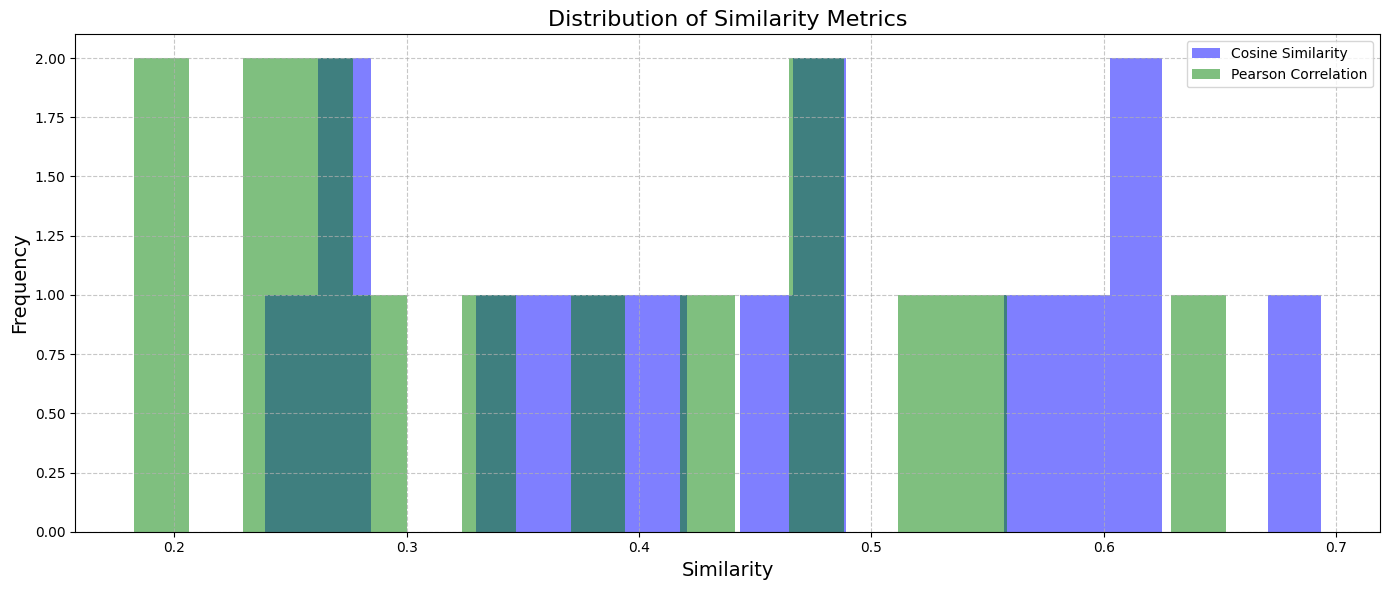

In [25]:
plt.figure(figsize=(14, 6))
plt.hist(cosine_similarities, bins=20, alpha=0.5, label="Cosine Similarity", color='blue')
plt.hist(pearson_correlations, bins=20, alpha=0.5, label="Pearson Correlation", color='green')
plt.title("Distribution of Similarity Metrics", fontsize=16)
plt.xlabel("Similarity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 14. Visualize Box Plot of Similarity Metrics

C:\Users\hclu1\AppData\Local\Temp\ipykernel_8056\2037923514.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cosine_similarities, pearson_correlations], labels=["Cosine Similarity", "Pearson Correlation"])


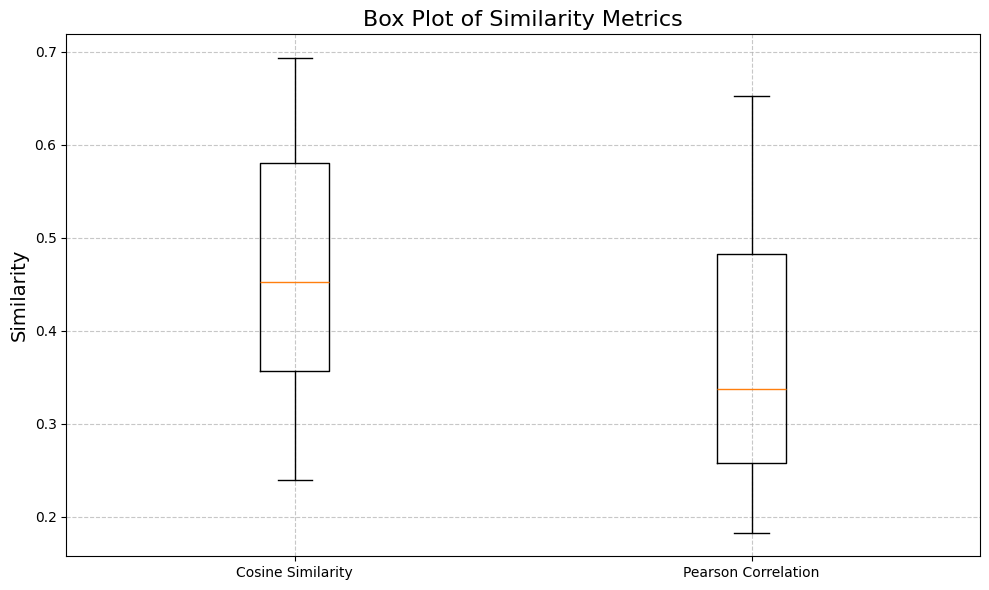

In [26]:
plt.figure(figsize=(10, 6))
plt.boxplot([cosine_similarities, pearson_correlations], labels=["Cosine Similarity", "Pearson Correlation"])
plt.title("Box Plot of Similarity Metrics", fontsize=16)
plt.ylabel("Similarity", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 15. Visualize Violin Plot of Similarity Metrics

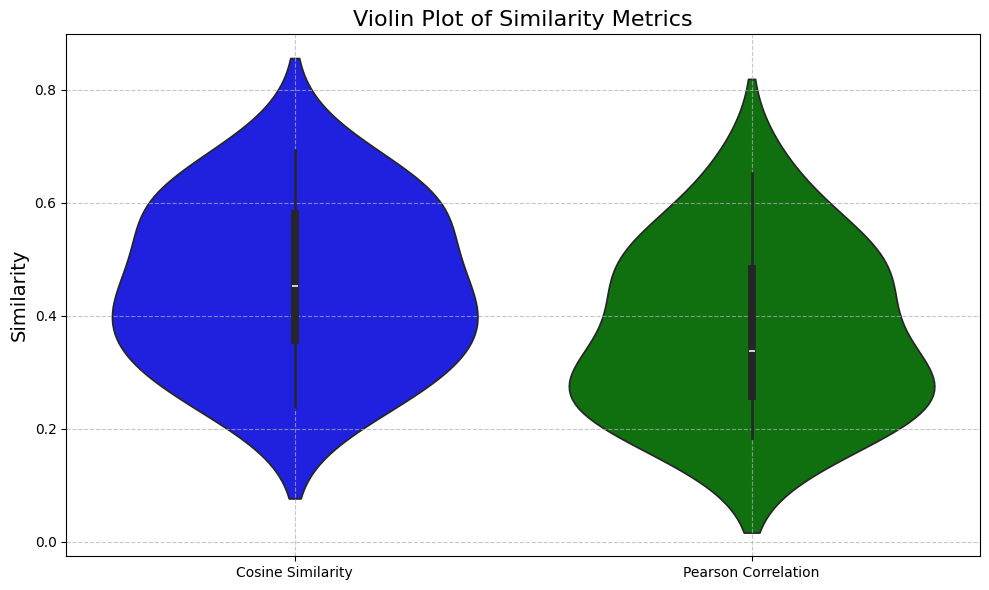

In [27]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=[cosine_similarities, pearson_correlations], palette=["blue", "green"])
plt.xticks([0, 1], ["Cosine Similarity", "Pearson Correlation"])
plt.title("Violin Plot of Similarity Metrics", fontsize=16)
plt.ylabel("Similarity", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 16.  Display Similarity Results as a DataFrame

In [28]:
# Display similarity results in a tabular format
from IPython.display import display

# Display the DataFrame in the notebook
print("Similarity Results for Corresponding Rows:")
display(similarity_df)

# Optionally save the results to a CSV file for review
similarity_df.to_csv("similarity_results.csv", index=False)
print("Similarity results saved to 'similarity_results.csv'")

Similarity Results for Corresponding Rows:


,Row Name,Cosine Similarity,Pearson Correlation
0,e80001,0.368932,0.251651
1,e80002,0.615457,0.519327
2,e80003,0.344265,0.275675
3,e80004,0.284268,0.190949
4,e80005,0.596285,0.546416
5,e80006,0.452267,0.423911
6,e80007,0.610257,0.484656
7,e80008,0.400099,0.263125
8,e80009,0.239046,0.182753
9,e80010,0.388922,0.299863


Similarity results saved to 'similarity_results.csv'


# 17. Mismatched Columns

Detailed mismatches with unit names and types:


,Row,Column,Unit Name,Mismatch Type,vector_output,test_csv
0,e80001,V2,puts soap on hand,Overestimation,1,0
1,e80001,V3,turns on water,Overestimation,1,0
2,e80001,V4,lathers and rinses hands under water,Overestimation,1,0
3,e80001,V5,turns off water,Overestimation,1,0
4,e80001,V15,opens fridge,Overestimation,1,0
...,...,...,...,...,...,...
262,e80015,V49,takes out fork,Underestimation,0,1
263,e80015,V52,opens egg carton,Overestimation,1,0
264,e80015,V54,closes egg carton,Overestimation,1,0
265,e80015,V64,puts butter on spatula,Underestimation,0,1



Total Overestimations: 141
Total Underestimations: 126


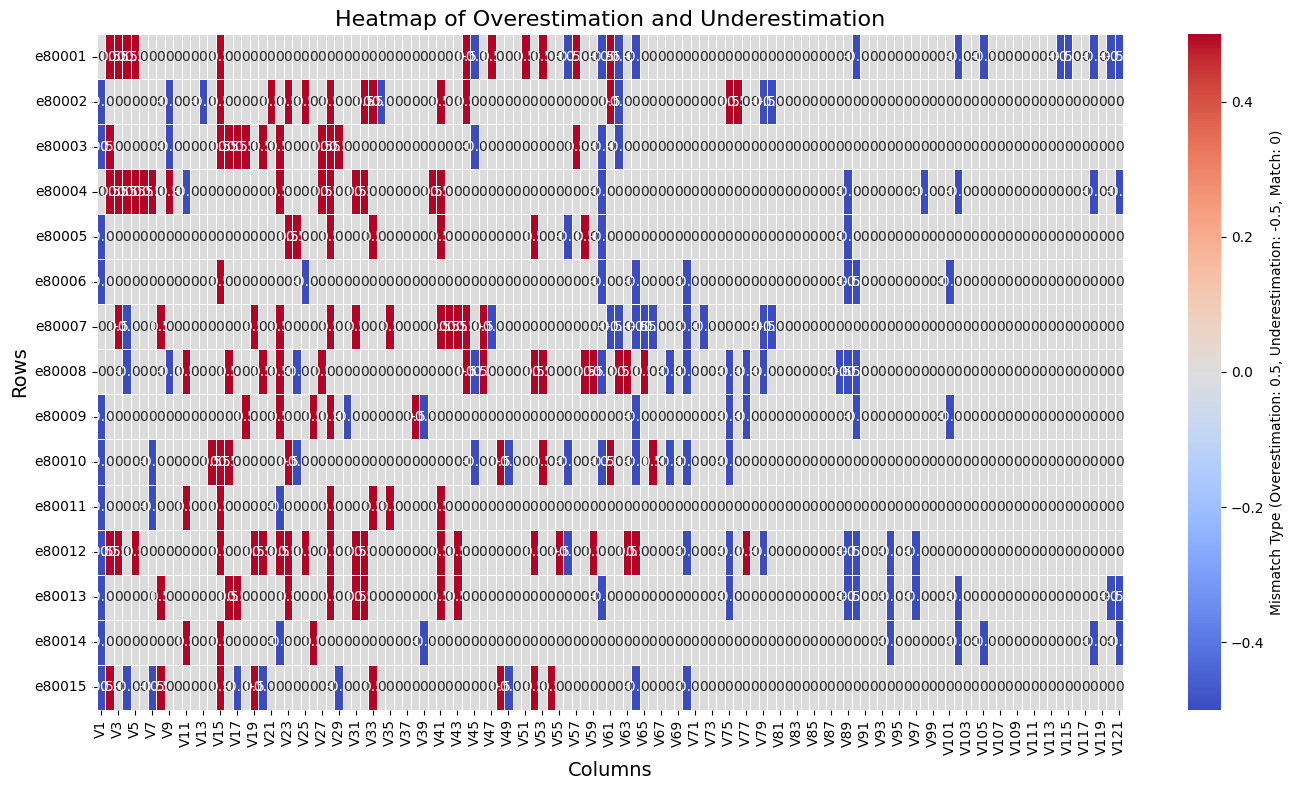

In [29]:
# Read A1 units from the specified CSV file
a1_units_path = "A1_Units_Breakfast.csv"
a1_units_df = pd.read_csv(a1_units_path)
A1_units = a1_units_df['A1_unit'].tolist()  # Convert the column to a list

# Map each column in vector_output/test_csv to its corresponding unit name
detail_mapping = {f"V{i+1}": detail for i, detail in enumerate(A1_units)}

# Create a DataFrame to track mismatch types (overestimation, underestimation, or match)
mismatch_matrix = pd.DataFrame(index=vector_output.index, columns=vector_output.columns)

for column in vector_output.columns:
    mismatch_matrix[column] = (vector_output[column] - test_csv[column]).apply(
        lambda x: 1 if x > 0 else (-1 if x < 0 else 0)  # Overestimation = 1, Underestimation = -1, Match = 0
    )

# Create a DataFrame to show mismatched rows and columns with unit names
mismatch_details = []
for row in mismatch_matrix.index:
    for column in mismatch_matrix.columns:
        if mismatch_matrix.loc[row, column] != 0:  # If there is a mismatch
            unit_name = detail_mapping.get(column, "Unknown Unit")
            mismatch_details.append({
                "Row": row,
                "Column": column,
                "Unit Name": unit_name,
                "Mismatch Type": "Overestimation" if mismatch_matrix.loc[row, column] == 1 else "Underestimation",
                "vector_output": vector_output.loc[row, column],
                "test_csv": test_csv.loc[row, column]
            })

mismatch_df = pd.DataFrame(mismatch_details)

# Count overestimations and underestimations
overestimations_count = len(mismatch_df[mismatch_df["Mismatch Type"] == "Overestimation"])
underestimations_count = len(mismatch_df[mismatch_df["Mismatch Type"] == "Underestimation"])

# Display the mismatch DataFrame
print("Detailed mismatches with unit names and types:")
display(mismatch_df)

# Print counts of overestimations and underestimations
print(f"\nTotal Overestimations: {overestimations_count}")
print(f"Total Underestimations: {underestimations_count}")

# Visualize mismatches with a heatmap (overestimation = 1, underestimation = -1, match = 0)
plt.figure(figsize=(14, 8))
sns.heatmap(
    mismatch_matrix.replace({1: 0.5, -1: -0.5}),  # Distinguish overestimation (light red) and underestimation (blue)
    cmap="coolwarm",
    linewidths=0.5,
    annot=True,
    cbar_kws={'label': 'Mismatch Type (Overestimation: 0.5, Underestimation: -0.5, Match: 0)'}
)
plt.title("Heatmap of Overestimation and Underestimation", fontsize=16)
plt.xlabel("Columns", fontsize=14)
plt.ylabel("Rows", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# 18. Over & Underestimation for Each Response


Mismatch counts for each row:


,Row,Overestimations,Underestimations,Total Mismatches
0,e80001,11,13,24
1,e80002,12,7,19
2,e80003,11,5,16
3,e80004,14,7,21
4,e80005,7,4,11
5,e80006,1,8,9
6,e80007,12,11,23
7,e80008,14,13,27
8,e80009,5,8,13
9,e80010,8,11,19


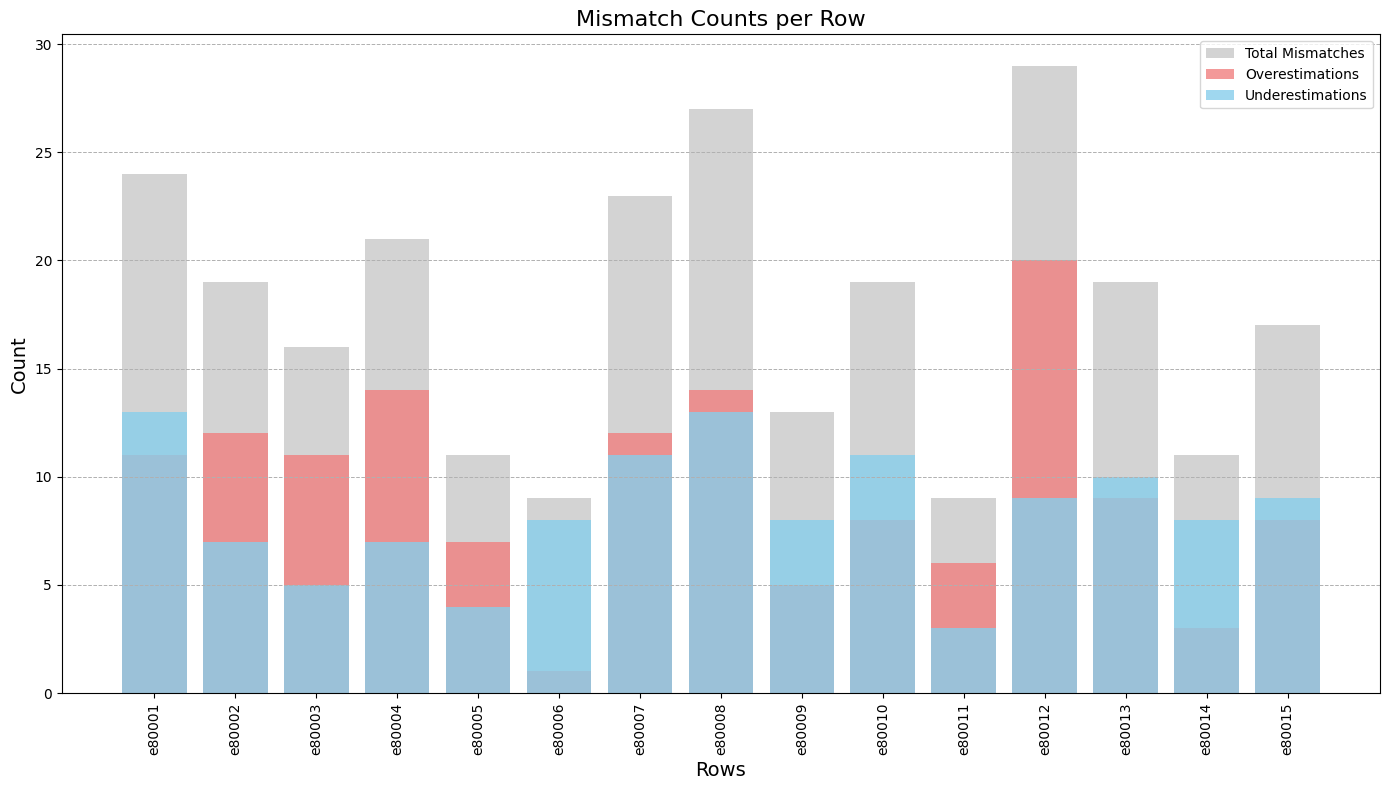

In [30]:
# Calculate total mismatches, overestimations, and underestimations for each row
row_mismatches = []
for row in mismatch_matrix.index:
    overestimations = (mismatch_matrix.loc[row] == 1).sum()
    underestimations = (mismatch_matrix.loc[row] == -1).sum()
    total_mismatches = overestimations + underestimations
    row_mismatches.append({
        "Row": row,
        "Overestimations": overestimations,
        "Underestimations": underestimations,
        "Total Mismatches": total_mismatches
    })

# Convert to a DataFrame
row_mismatch_df = pd.DataFrame(row_mismatches)

# Display the DataFrame
print("\nMismatch counts for each row:")
display(row_mismatch_df)

# Visualization: Bar plot for each row's total, over, and underestimations
plt.figure(figsize=(14, 8))
x = row_mismatch_df['Row']
plt.bar(x, row_mismatch_df['Total Mismatches'], label='Total Mismatches', color='lightgray')
plt.bar(x, row_mismatch_df['Overestimations'], label='Overestimations', color='lightcoral', alpha=0.8)
plt.bar(x, row_mismatch_df['Underestimations'], label='Underestimations', color='skyblue', alpha=0.8)

# Add labels and title
plt.xlabel("Rows", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Mismatch Counts per Row", fontsize=16)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()
